In [1]:
import requests
from bs4 import BeautifulSoup
import wikipediaapi
import pandas as pd
from googletrans import Translator

In [2]:
####################Extract Top 50 Wikipedia Articles in 2019 list
source = requests.get("https://en.wikipedia.org/wiki/Wikipedia:2019_Top_50_Report").text
soup = BeautifulSoup(source,'lxml')

#Get table containing required content
table = soup.find("table", class_="wikitable")
rows = table.find_all("tr")
del rows[0] #Remove headers in table

#Grab all 50 topics
topics = [row.a.text for row in rows]
unwanted = ["List of highest-grossing films","Deaths in 2019","List of Bollywood films of 2019","2019 in film","Murder of Dee Dee Blanchard"]
#Remove unwanted Non-Articles
topics = [topic for topic in topics if topic not in unwanted]
#Include other articles instead
topics += ["Natural language processing","Data Science","Artificial intelligence","Machine learning","Singapore"]



###################Extract summary text of articles
languages = ["fr","zh"] #Langauges include English, French and Chinese
wiki = wikipediaapi.Wikipedia('en')

#Dataframe which will store the textual data (summary of articles)
df = pd.DataFrame(columns = ['Original Title','Language','Text'])

#Scrape and append
for topic in topics:
    #print('Extracting Text for: {}'.format(topic))
    page_py = wiki.page(topic)
    df = df.append(pd.Series([topic,"en",page_py.summary], index = df.columns),ignore_index=True) 
    for lang in languages:
        page_py_lang = page_py.langlinks[lang]
        df = df.append(pd.Series([topic,lang,page_py_lang.summary], index = df.columns),ignore_index=True) 

In [3]:
print(df)

                              Original Title Language  \
0                          Avengers: Endgame       en   
1                          Avengers: Endgame       fr   
2                          Avengers: Endgame       zh   
3                                  Ted Bundy       en   
4                                  Ted Bundy       fr   
5                                  Ted Bundy       zh   
6                            Freddie Mercury       en   
7                            Freddie Mercury       fr   
8                            Freddie Mercury       zh   
9                         Chernobyl disaster       en   
10                        Chernobyl disaster       fr   
11                        Chernobyl disaster       zh   
12                         Joker (2019 film)       en   
13                         Joker (2019 film)       fr   
14                         Joker (2019 film)       zh   
15   List of Marvel Cinematic Universe films       en   
16   List of Marvel Cinematic U

In [4]:
######################Language Detection & Translation
#Initialise translator object
#translator = Translator()
translator = Translator(service_urls=[
        #'translate.google.com',
        'translate.google.co.kr',
        ])

all_translated = [] #Translated Texts
all_src = [] #Detected Languages

#Translate & Detect Language for all text
for i in range(df.shape[0]):
    #Print Translation Progress
    #print("Translating for '{}' ({})".format(df.loc[i]['Original Title'],df.loc[i]['Language']))
    translated = translator.translate(df.loc[i]['Text'], dest='en')
    all_translated.append(translated.text)
    all_src.append(translated.src)
    
#Append Translations and Detected Langauges
df['Detected Language'] = all_src
df['Translated Text'] = all_translated

In [5]:
print(df)

                              Original Title Language  \
0                          Avengers: Endgame       en   
1                          Avengers: Endgame       fr   
2                          Avengers: Endgame       zh   
3                                  Ted Bundy       en   
4                                  Ted Bundy       fr   
5                                  Ted Bundy       zh   
6                            Freddie Mercury       en   
7                            Freddie Mercury       fr   
8                            Freddie Mercury       zh   
9                         Chernobyl disaster       en   
10                        Chernobyl disaster       fr   
11                        Chernobyl disaster       zh   
12                         Joker (2019 film)       en   
13                         Joker (2019 film)       fr   
14                         Joker (2019 film)       zh   
15   List of Marvel Cinematic Universe films       en   
16   List of Marvel Cinematic U

In [6]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import string
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import re
from yellowbrick.cluster import KElbowVisualizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ML\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ML\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ML\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


C:\Users\ML\Desktop\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
#####################Text Processing
def text_process(text):
    '''
    Performs the following given input text:
    - Removal of non-ASCII characters (non-translated foreign characters)
    - Removal of punctuation
    - Tokenization & removal of whitespace
    - Convertion to lowercase
    - Removal of stop words
    - Lemmatization
    '''
    stemmer = WordNetLemmatizer()
    #Remove non-ASCII characters (non-translated foreign characters)
    text = text.encode("ascii", errors="ignore").decode()
    #Remove numbers
    #text = re.sub(r'\d+', '', text)
    #Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    #Tokenize & remove whitespace
    tokens = word_tokenize(text)
    #Remove stop words & convert to lowercase
    nostop =  [word.lower() for word in tokens if word not in stopwords.words('english')]
    #Lemmatize
    return [stemmer.lemmatize(word) for word in nostop]

#Initialize tfidf vectorizer    
tfidf = TfidfVectorizer(analyzer=text_process)
#Fit text
print('Vectorizing Text....')
X = tfidf.fit_transform(df['Translated Text'])
#Tfidf matrix
X_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names())

#Dimensionality Reduction 
seed = 42 #Set random seed for reproducability
np.random.seed(seed)
print('Reducing Dimensions....')
svd = TruncatedSVD(n_components=150, random_state=seed)
X_reduce = svd.fit_transform(X)

Vectorizing Text....
Reducing Dimensions....


Fitting K-Means....


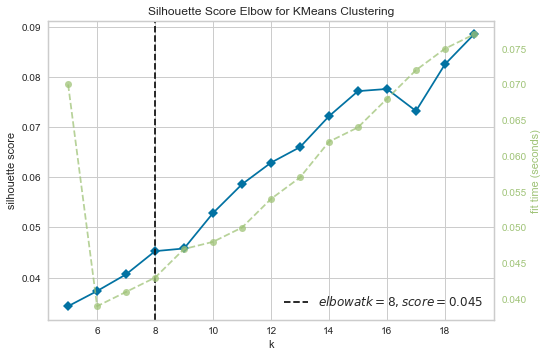

In [11]:
####################K-Means Clustering
#Employ Elbow Method to estimate possible k
print('Fitting K-Means....')
model = KMeans(random_state=seed)
visualizer = KElbowVisualizer(model, k= (5,20), metric='silhouette')

visualizer.fit(X_reduce) # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [12]:
##################Analysis of Chosen K
chosen = visualizer.elbow_value_ #Pit of Elbow (Chosen k)
kmeans = KMeans(n_clusters=chosen, random_state=seed)
kmeans.fit(X_reduce)
df['Cluster'] = kmeans.labels_

#Check articles of different langauges
topics = np.unique(df['Original Title'])
mismatch = [] #Store mismatched topics

for topic in topics:
    topic_df = df.loc[df['Original Title'] == topic]
    #Mismatch if more ore than 1 unique cluster per topic:
    if len(np.unique(topic_df['Cluster'])) > 1:
        mismatch.append(topic)
        #print(topic_df[['Original Title','Cluster']])
     
print('Total Mismatch Count: {}'.format(len(mismatch)))
print('Mismatched Articles: {}'.format(mismatch))

Total Mismatch Count: 7
Mismatched Articles: ['Central Park jogger case', 'Elon Musk', 'Jason Momoa', 'Joker (2019 film)', 'Kamala Harris', 'Keanu Reeves', 'Nipsey Hussle']


In [13]:
#Cluster Contents
clusters = {}
for i in range(chosen):
    clusters[i] = []

for topic in topics:
    topic_df = df.loc[df['Original Title'] == topic]
    cluster_pred = topic_df['Cluster']
    
    #No Majority Cluster, Choose English
    if len(np.unique(cluster_pred)) == 3:
        eng_cluster = int(topic_df.loc[df['Detected Language'] == 'en','Cluster'])
        #Append topic to english cluster
        clusters[eng_cluster].append(topic)
        continue
    
    #Append Majority Cluster
    maj_cluster = max(list(cluster_pred), key=list(cluster_pred).count)
    clusters[maj_cluster].append(topic)
    
#Print cluster contents
for cluster in clusters:
    print('Cluster {}: {}'.format(cluster,clusters[cluster]))  

Cluster 0: ['Alexandria Ocasio-Cortez', 'Donald Trump', 'Jeffrey Epstein', 'Ted Bundy']
Cluster 1: ['Bradley Cooper', 'Joaquin Phoenix', 'Joker (2019 film)', 'Nipsey Hussle', 'Rami Malek']
Cluster 2: ['Bonnie and Clyde', 'Cameron Boyce', 'Chernobyl disaster', 'Jason Momoa', 'Luke Perry', 'Once Upon a Time in Hollywood', 'Star Wars: The Rise of Skywalker', 'The Irishman', 'The Lion King (2019 film)', 'United States', 'Us (2019 film)']
Cluster 3: ['Avengers: Endgame', 'Captain Marvel (film)', 'List of Marvel Cinematic Universe films', 'Marvel Cinematic Universe', 'Spider-Man: Far From Home']
Cluster 4: ['Game of Thrones', 'Game of Thrones (season 8)', 'The Mandalorian']
Cluster 5: ['Artificial intelligence', 'Data Science', 'Machine learning', 'Natural language processing']
Cluster 6: ['2019 Indian general election', 'Cristiano Ronaldo', 'Dwayne Johnson', 'Elon Musk', 'India', 'Kamala Harris', 'Singapore', 'TikTok', 'YouTube']
Cluster 7: ['Billie Eilish', 'Central Park jogger case', 'Eli

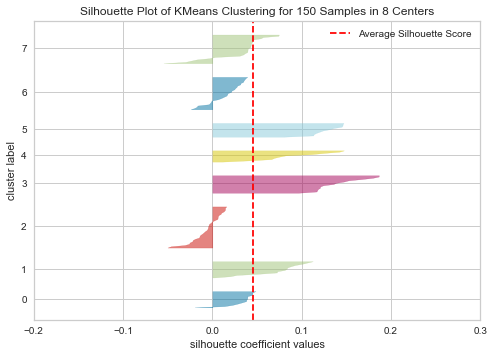

In [14]:
#Cluster Visualizations
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(X_reduce) # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

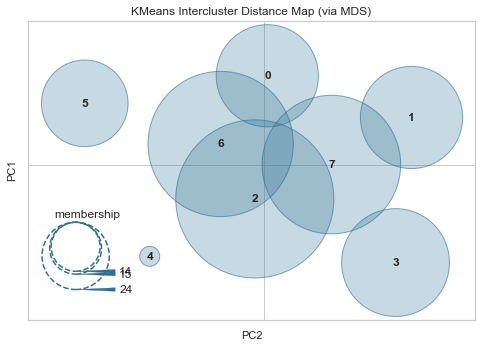

In [15]:
from yellowbrick.cluster import InterclusterDistance
visualizer = InterclusterDistance(kmeans)

visualizer.fit(X_reduce) # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure